In [4]:
import wotplot
from matplotlib import pyplot

# 1. The simple example from the README

## 1.1. Define a small dataset

In [5]:
s1 = "AGCAGGAGATAAACCTGT"
s2 = "AGCAGGTTATCTACCTGT"
k = 3

## 1.2. Create a dot plot matrix

In [6]:
m = wotplot.make(s1, s2, k)

## 1.3. Inspect the dot plot matrix

In [7]:
type(m)

wotplot._matrix.DotPlotMatrix

In [8]:
m

DotPlotMatrix(mat=<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>, s1="AGCAGGAGATAAACCTGT", s2="AGCAGGTTATCTACCTGT", k=3, yorder="BT", binary=True)

In [9]:
print(str(m))

DotPlotMatrix(k = 3, binary, bottom → top): 16x16


The `DotPlotMatrix` object we just created, `m`, contains some extra information about the way it was created (e.g. the value of `k` we used). But the most interesting part of it is the actual matrix describing the dot plot! This matrix is stored in the `mat` attribute.

In [10]:
m.mat

<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>

### 1.3.1. Why is this matrix 16x16? Shouldn't it be 18x18?

You might have noticed that `s1` and `s2` are 18 nucleotides long. Why, then, does `m.mat` only have 16 rows and 16 columns?

The reason for this is that, in an arbitrary string $s$, the number of $k$-mers is $|s| - k + 1$. For `s1` and `s2`, $|s| - k + 1 = 18 - 3 + 1 = 16$.

A way of thinking about this: the last 3-mer in `s1` is `TGT`, starting at the 16th position in `s1` (using 1-indexing). There are always going to be $k - 1$ characters left over (for `s1`, these are the final `G` and `T`) where no $k$-mers can begin.

### 1.3.2. What's the deal with sparse matrices?

Most dot plot matrices are _sparse_: that is, most of their entries are zeroes. We exploit this by storing our matrices as [sparse matrices](https://en.wikipedia.org/wiki/Sparse_matrix)—these objects drastically reduce the memory requirements when our input sequences are long (more than a few thousand nucleotides).

It's possible to convert our sparse matrix back to an equivalent "dense" matrix; this can make these matrices easier to work with, although it might require a large amount of memory if your input sequences were long. Here's an example of creating a dense copy of `m.mat`:

In [8]:
m.mat.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 1.3.3. Sidenote about the matrix type
Depending on the version of SciPy you have installed, this matrix will have the type [`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (SciPy < 1.8) or  [`scipy.sparse.coo_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html) (SciPy ≥ 1.8). There shouldn't be much of a difference, at least for our use of these objects.

## 1.4. Visualize the dot plot matrix

In [12]:
import seaborn
ax.imshow(m.mat.toarray())

NameError: name 'ax' is not defined

In [64]:

import matplotlib.lines as mlines

In [20]:
import matplotlib
matplotlib.__version__

'3.3.4'

In [43]:
Z = np.asarray(m.mat)

In [44]:
mask = np.abs(Z) > 0

In [55]:
c = m.mat.tocoo()

In [59]:
m.mat.col

array([ 0,  1,  2,  2,  3,  3,  6,  7,  8,  9, 11, 12, 12, 13, 13, 14, 14,
       15], dtype=int32)

In [60]:
m.mat.row

array([15, 14,  1, 13,  2, 12,  6,  7,  8,  9, 10,  3, 11,  2, 12,  1, 13,
        0], dtype=int32)

In [26]:
import numpy as np

In [11]:
m2 = wotplot.make("ACAGGGAT", s2, k)

In [12]:
m2.mat.toarray()

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

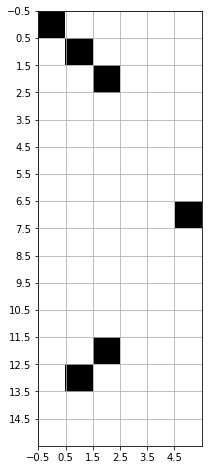

In [22]:
import betterspy
betterspy.plot(m2.mat, colormap="gray_r")
pyplot.xticks([x - 0.5 for x in range(0, m2.mat.shape[1])])
pyplot.yticks([x - 0.5 for x in range(0, m2.mat.shape[0])])
pyplot.gcf().set_size_inches(8, 8)
pyplot.grid()

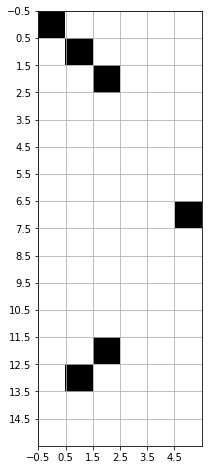

In [317]:
fig, ax= pyplot.subplots()
ax.imshow(m2.mat.toarray(), cmap="gray_r")
ax.set_xticks([x - 0.5 for x in range(0, mat.shape[1])])
ax.set_yticks([x - 0.5 for x in range(0, mat.shape[0])])
ax.grid()
fig.set_size_inches(8, 8)

In [237]:
type(ax.get_window_extent())

matplotlib.transforms.TransformedBbox

In [242]:
print(fig.dpi_scale_trans.inverted())

Affine2D(
    [[0.01388889 0.         0.        ]
     [0.         0.01388889 0.        ]
     [0.         0.         1.        ]])


In [287]:
from math import sqrt

In [288]:
sqrt(720)

26.832815729997478

In [286]:
(0.377499999 * 72)**2

738.7523960860799

In [291]:
(0.2359 * 72) ** 2

288.48343103999997

In [326]:
help(matplotlib.axes.Axes)

Help on class Axes in module matplotlib.axes._axes:

class Axes(matplotlib.axes._base._AxesBase)
 |  The `Axes` contains most of the figure elements: `~.axis.Axis`,
 |  `~.axis.Tick`, `~.lines.Line2D`, `~.text.Text`, `~.patches.Polygon`, etc.,
 |  and sets the coordinate system.
 |  
 |  The `Axes` instance supports callbacks through a callbacks attribute which
 |  is a `~.cbook.CallbackRegistry` instance.  The events you can connect to
 |  are 'xlim_changed' and 'ylim_changed' and the callback will be called with
 |  func(*ax*) where *ax* is the `Axes` instance.
 |  
 |  Attributes
 |  ----------
 |  dataLim : `.Bbox`
 |      The bounding box enclosing all data displayed in the Axes.
 |  viewLim : `.Bbox`
 |      The view limits in data coordinates.
 |  
 |  Method resolution order:
 |      Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  acorr(self, x, *, data=None, **kwargs)
 |      Plot the

In [325]:
type(ax) == matplotlib.axes.Axes

False

In [305]:
mat.col

array([2, 1, 0, 1, 2, 5], dtype=int32)

142.69499999999996 380.52
23.782499999999995 23.7825
72.0
565.6073062499997


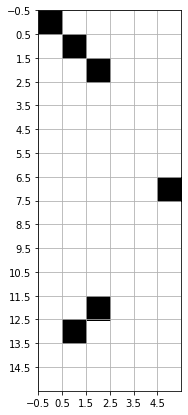

In [328]:
mat = m2.mat
fig, ax = pyplot.subplots()
# Replicate what ax.spy() does -- based on
# https://matplotlib.org/3.3.4/_modules/matplotlib/axes/_axes.html#Axes.spy
# ax.add_line(mlines.Line2D(m.mat.col, m.mat.row, marker="s", markersize=12.79))
ax.set_xlim(-0.5, mat.shape[1] - 0.5)
ax.set_ylim(mat.shape[0] - 0.5, 0.5)
ax.set_xticks([x - 0.5 for x in range(0, mat.shape[1])])
ax.set_yticks([x - 0.5 for x in range(0, mat.shape[0])])
fig.set_size_inches(7,7)
ax.set_aspect("equal")
# if we don't do this then the bbox is wrong
ax.apply_aspect()
ax.grid()
bbox = ax.get_window_extent()
w = bbox.width
h = bbox.height
print(w, h)
w_per_cell = w / mat.shape[1]
h_per_cell = h / mat.shape[0]
print(w_per_cell, h_per_cell)
print(fig.dpi)
cell_area = w_per_cell**2
print(cell_area)
ax.scatter(mat.col, mat.row, marker="s", color="#000", s=cell_area)

1.1324999999999998 3.0199999999999996
0.18874999999999997 0.18874999999999997
72.0


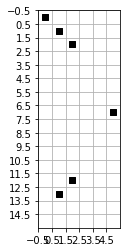

In [228]:
def viz(mat):
    fig, ax = pyplot.subplots()
    # Replicate what ax.spy() does -- based on
    # https://matplotlib.org/3.3.4/_modules/matplotlib/axes/_axes.html#Axes.spy
    # ax.add_line(mlines.Line2D(m.mat.col, m.mat.row, marker="s", markersize=12.79))
    ax.set_xlim(-0.5, mat.shape[1] - 0.5)
    ax.set_ylim(mat.shape[0] - 0.5, 0.5)
    ax.set_xticks([x - 0.5 for x in range(0, mat.shape[1])])
    ax.set_yticks([x - 0.5 for x in range(0, mat.shape[0])])
    ax.set_aspect("equal")
    # if we don't do this then the bbox is wrong
    ax.apply_aspect()
#     fig.set_size_inches(8, 8)
    ax.grid()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    w = bbox.width
    h = bbox.height
    print(w, h)
    w_per_cell = w / mat.shape[1]
    h_per_cell = h / mat.shape[0]
    print(w_per_cell, h_per_cell)
    print(fig.dpi)
    ax.scatter(mat.col, mat.row, marker="s", color="#000", s=w_per_cell * fig.dpi * 2)
viz(m2.mat)

In [200]:
81.5399 / 6

13.589983333333334

In [202]:
217.44 / 16

13.59

In [110]:
bbox.width

217.44

In [96]:
bbox.width

217.44

In [103]:
15.5 - (-0.5) + 1

17.0

In [101]:
217.44 / 17

12.790588235294118

In [69]:
w, h = bbox.width, bbox.height

In [74]:
tw = w * fig.dpi

In [75]:
th = h * fig.dpi

In [78]:
th /16

13.589999999999998

In [ ]:
fig, ax = pyplot.subplots()
ax.spy(m.mat, color="#000", markersize=)
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

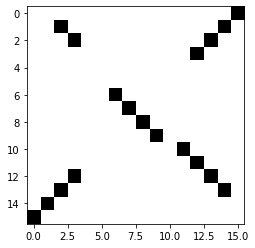

In [15]:
betterspy.plot(m.mat, colormap="gray_r")

In [13]:
help(betterspy)

Help on package betterspy:

NAME
    betterspy

PACKAGE CONTENTS
    __about__
    cli
    main

FUNCTIONS
    plot(A, border_width=0, border_color='0.5', colormap=None)
    
    show(*args, **kwargs)
    
    write_png(filename, A, border_width=0, border_color='0.5', colormap=None)

DATA
    __all__ = ['__version__', 'cli', 'plot', 'show', 'write_png']

VERSION
    0.1.6

FILE
    /home/marcus/anaconda3/envs/wotplot-py36/lib/python3.6/site-packages/betterspy/__init__.py




In [114]:
import cv2
import numpy as np
from math import ceil
from matplotlib import pyplot
from matplotlib.ticker import MaxNLocator

# Based on the opencv tutorial linked in viz_binary()'s docstring
DILATION_KERNEL = np.ones((5, 5), np.uint8)


def _tidy_dotplot_viz_ax(ax, m):
    # Force matplotlib to only use integer ticks:
    # https://stackoverflow.com/a/38096332
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Hide the ticks / tick labels.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Based on the mutation matrix drawn in
    # https://nbviewer.org/github/fedarko/strainFlye/blob/main/docs/SheepGutExample.ipynb
    ax.tick_params(
        top=True,
        bottom=True,
        left=True,
        right=True,
        labeltop=True,
        labelbottom=True,
        labelleft=True,
        labelright=True,
    )

    ax.set_xlabel(f"$s_1$ ({len(m.s1):,} nt) \u2192", fontsize=18)
    if m.yorder == "BT":
        # -->, which gets turned into an up arrow when we rotate the yax label
        yarr = "\u2192"
    elif m.yorder == "TB":
        # <--, which gets turned into a down arrow when we rotate the yax label
        yarr = "\u2190"
    else:
        raise ValueError(f"Unrecognized yorder?: {m.yorder}")
    ax.set_ylabel(f"$s_2$ ({len(m.s2):,} nt) {yarr}", fontsize=18)


def viz_binary(m, num_dilation_iterations="auto", title=None, ax=None):
    """Visualizes a DotPlotMatrix object.

    This is intended to be used on binary DotPlotMatrix objects only.

    References
    ----------
    https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
        OpenCV tutorial on dilation and other morphological operations.

    https://stackoverflow.com/q/44618675
        The answers to this question showed me the light (of image processing
        101) (I didn't know what a dilation was)
    """
    if not m.binary:
        raise ValueError(
            "Can't use viz_binary() on a DotPlotMatrix that is not binary."
        )

    if num_dilation_iterations == "auto":
        maxlen = max(len(m.s1), len(m.s2))
        # Don't bother doing dilation for small matrices
        if maxlen < 500:
            num_dilation_iterations = 0
        else:
            # sloppy stuff, TODO replace (also check stuff in [500, 2500))
            num_dilation_iterations = 4 + ceil((maxlen - 2500) / 2500)

    if num_dilation_iterations > 0:
        matrix_to_show = cv2.dilate(
            m.mat, DILATION_KERNEL, iterations=num_dilation_iterations
        )
    else:
        matrix_to_show = m.mat

    return_mplobjs = False
    if ax is None:
        return_mplobjs = True
        fig, ax = pyplot.subplots()

    ax.spy(matrix_to_show, color="#000", markersize=12)

#     _tidy_dotplot_viz_ax(ax, m)

    if title is not None:
        ax.set_title(title, fontsize=18)

    if return_mplobjs:
        return fig, ax


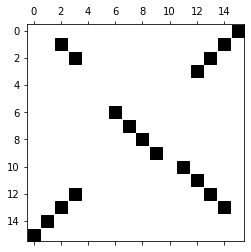

In [115]:
fig, ax = viz_binary(m)
# fig.set_size_inches(8,8)
# Save the visualization to a file
fig.savefig("example_dotplot.png", bbox_inches="tight")

# 2. An example of tiling multiple dot plots

... and messing around with a few of matplotlib's many options.

Notice how we provide an argument to the `ax` parameter of `wotplot.viz_binary()` -- this way, we can create these `Axes` objects in advance (when we call `pyplot.subplots`). By controlling the figure's layout from the start, we have a lot of control over what it'll end up looking like.

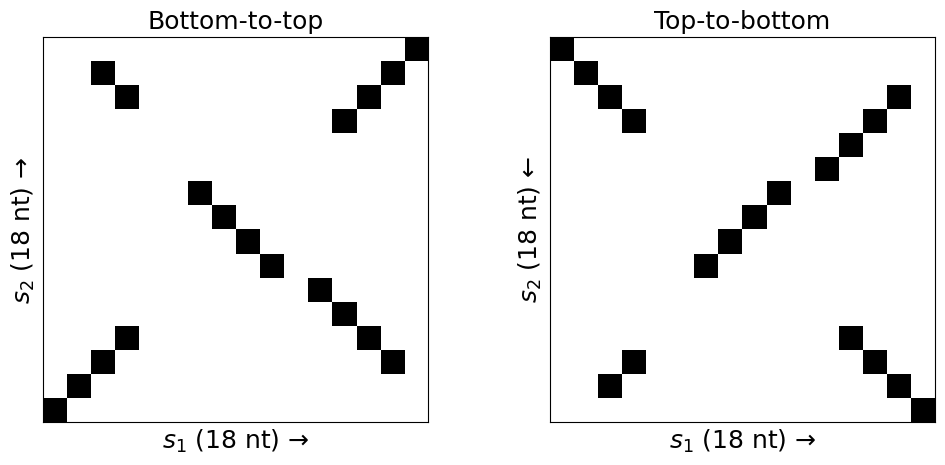

In [18]:
m_flipped = wotplot.make(s1, s2, k, yorder="TB")

fig, (axLeft, axRight) = pyplot.subplots(1, 2)
wotplot.viz_binary(m, ax=axLeft)
wotplot.viz_binary(m_flipped, ax=axRight)

axLeft.set_title('Bottom-to-top', fontsize=18)
axRight.set_title('Top-to-bottom', fontsize=18)

fig.set_size_inches(12, 5)